# Машинное обучение, DS-поток
## Домашнее задание 2

**Правила:**

* Дедлайн **28 февраля 10:00**. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить на почту ` mipt.stats@yandex.ru`, указав тему письма `"[ml] Фамилия Имя - задание 2"`. Квадратные скобки обязательны. Если письмо дошло, придет ответ от автоответчика.
* Прислать нужно ноутбук и его pdf-версию (без архивов). Названия файлов должны быть такими: `2.N.ipynb` и `2.N.pdf`, где `N` - ваш номер из таблицы с оценками.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качествие основы, ничего не удаляя из него.
* Никакой код из данного задания при проверке запускаться не будет.

**Баллы за задание:**

* Задача 1 -  5 баллов
* Задача 2 -  15 баллов

In [450]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sps
from scipy.special import logsumexp
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from time import time
import warnings

sns.set_style("dark")
sns.set(font_scale=1.4)
warnings.filterwarnings('ignore')

### Задача 1

Рассмотрим метод *логистической регрессии*. Пусть $x_i \in \mathbb{R}^d, Y_i \sim Bern(\mu_\theta(x_i))$. 

Мы предполагаем, что $\mu_\theta(x_i) = P_\theta(Y_i = 1)  = \sigma(x_i^T\theta)= \frac{e^{x_i^T\theta}}{1 + e^{x_i^T\theta}}$.

Регуляризацию в методе логистической регрессии можно задать с помощью введения априорного распределения на $\theta$. Будем считать, что априорное распределения $\mathcal{N}(0, \alpha^{-1}I_d)$. В данном случае распределения не являются сопряженными, поэтому простым путем найти апостериорное распределение не получится. Однако, можно найти моду этого распределения. Выпишите соответствующую задачу оптимизации.

Для данной задачи:
1. Получите формулу градиентного спуска.
2. Получите формулу метода IRLS.

### Решение  
Пусть на параметре $\theta$ введено априорное распределение $\mathcal{N}(0, \alpha^{-1}I_d)$.  
Т.е. $p(t) = \left(\frac{\alpha}{2\pi}\right)^{\frac{d}{2}} e^{-\frac{\alpha}{2} t^T t}$  
Рассмотрим в качестве плотности при фиксированном значении $\theta = t$:

$$
p_t(X, Y) = \prod\limits_{i=1}^{n} \mu_{t}(x_i)^{Y_i} \mu_{t}(-x_i)^{1 - Y_i}
$$

где $\mu_{t}(x_i) = P_t(Y_i = 1)  = \sigma(x_i^T t)= \frac{1}{1 + e^{-x_i^T t}}$.  
Апостериорное распределение:

$$
q(t | X, Y) = p_t(X, Y) q(t) \propto \left( \prod\limits_{i=1}^{n} \mu_{t}(x_i)^{Y_i} \mu_{t}(-x_i)^{1 - Y_i} \right) \left(\frac{\alpha}{2\pi}\right)^{\frac{d}{2}} e^{\frac{\alpha}{2} t^T t}
$$

Заметим, мода распределения $= \underset{t}{\mathrm{argmax}}  q(t | X, Y) = \underset{t}{\mathrm{argmax}} \log q(t | X, Y)$ и не меняется в зависимости от $const$. Поэтому можем пользоваться пропорциональностью.  

Логарифмируем $q(t | X, Y)$

$$
F(t) = \log q(t | X, Y) \propto \sum\limits_{i=1}^{n} \left(Y_i \log \mu_t(x_i) + (1 - Y_i) \log \mu_t(-x_i) \right) + \log p(t) =
$$
$$
= \sum\limits_{i=1}^{n} \left(Y_i \log \sigma(x_i^T t) + (1 - Y_i) \log \sigma(-x_i^T t) \right) + -\frac{\alpha}{2} t^T t + \log \left(\frac{\alpha}{2\pi}\right)^{\frac{d}{2}}
$$

Найдем градиент (в дальнейшем опускаю знак $\propto$):

$$
\nabla \log q(t | X, Y) = - \alpha t + X^T (Y - S(t))
$$

где 
$$
S(t) = 
\begin{pmatrix}
\sigma(x_1^T t) \\
...\\
\sigma(x_n^T t)
\end{pmatrix}
,X(t) = 
\begin{pmatrix}
x_1^T \\
...\\
x_n^T
\end{pmatrix}
,Y = 
\begin{pmatrix}
Y_1 \\
...\\
Y_n
\end{pmatrix}
$$

Т.е. формула градиентного подъема имеет вид:
$$
\theta_{t+1} = \theta_t + \eta \left(X^T (Y - S(\theta_t)) - \alpha \theta_t) \right)
$$

Найдем гессиан:

$$
\nabla \nabla F(t) = -X^T V(t) X - \alpha I_d
$$, 
где $V(t) = diag(\sigma(x_i^T t)(1 - \sigma(x_i^T t)))$

Т.е.формула для метода IRLS:

$$
\theta_{t+1} = \theta_t + (X^T V(\theta_t) X + \alpha I_d)^{-1}(X^T (Y - S(\theta_t)) - \alpha \theta_t)
$$

### Задача 2

**1.**

Реализуйте логистическую регрессию с регуляризацией для трех вариантов поиска оценки параметров:
* обычный градиентный спуск;
* стохастический mini-batch градиентный спуск, размер батча 5-10;
* IRLS.

Для измерения времени работы **каждого** шага используйте 

`from time import time`

*Замечание.* Для чистоты эксперимента время шага внутри цикла `for` нужно замерять от конца предыдущего шага до конца текущего, а не от начала текущего шага.

In [521]:
class LogisticRegression():
    '''
    Модель логистической регрессии. Имеет следующие гиперпараметры:
    
    * alpha: параметр регуляризации. 
             Если равно 0, то регуляризация не происходит.
    * lr: константа, на которую домножаем градиент при обучении
    * eps: ограничение на норму невязки в случае
           если используется критерий criterion='eps'
    * max_iter: ограничение на кол-во итераций в случае 
                если используется критерий criterion='max_iter'
    * method: если равно 'gd', то используется обычный градиентный спуск,
              если равно 'sgd', то используется стохастический 
                    градиентный спуск,
              если равно 'irls', то используется метод IRLS.
    * criterion: если равно 'eps', то используем ограничение 
                    на норму невязки,
                 если равно 'max_iter', то используем ограничение 
                    на количество итераций
    * fit_intercept: указывает, следует ли добавить константу в признаки
    * save_history: указывает, следует ли сохранять историю обучения
    '''
    

    def __init__(self, alpha=0, lr=0.001, eps=1e-3, max_iter=1e1,
                 method='gd', criterion='max_iter', 
                 fit_intercept=True, save_history=True):
        ''' Создает модель и инициализирует параметры '''

        assert criterion in ['max_iter', 'eps'], 'выбран неправильный критерий остановки'
        assert method in ['gd', 'sgd', 'irls'], 'выбран неправильный метод'

        self.alpha = alpha
        self.lr = lr
        self.eps = eps
        self.max_iter = max_iter
        self.criterion = criterion
        self.method = method
        self.fit_intercept = fit_intercept
        self.save_history = save_history
        self.history = []  # для хранения истории обучения
        self.t = None

        
    @staticmethod
    def _sigmoid(x):
        return 1 / (1 + np.exp(-x))

    
    def _log_likelihood (self, X, y):
        zeros = np.zeros(X.shape[0])
        X_dot_t = np.dot(X, self.t)
        data = np.hstack([np.expand_dims(zeros, axis=1), np.expand_dims(X_dot_t, axis=1)])
        log_likehood = -np.sum(y * logsumexp(-data, axis=1) + 
                              (1 - y) * logsumexp(data, axis=1))
        return log_likehood - self.alpha / 2 * self.t.T @ self.t

    
    def _add_intercept(self, X):
        ''' 
        Добавляем свободный коэфициент к нашей модели. 
        Это происходит путем добавления вектора из 1 к исходной матрице.
        '''
        
        X_copy = np.full((X.shape[0], X.shape[1] + 1), fill_value=1.)
        X_copy[:, :-1] = X
        return X_copy
    
    def _criterion(self, t_pred, num_iters):
        if self.criterion == 'eps':
            return np.sqrt(np.sum((self.t - t_pred)**2)) < self.eps
        if self.criterion == 'max_iter':
            return num_iters >= int(self.max_iter)
            
    def _fit_epoch(self, X, Y):
        if self.method == 'gd':
            self.t += self.lr * (X.T @ (Y - self._sigmoid(np.dot(X, self.t)))
                                 - self.alpha * self.t)
        if self.method == 'sgd':
            num = 5
            batch_ind = np.random.randint(low=0, high=X.shape[0], size=num)
            self.t += self.lr * (X[batch_ind].T @ (Y[batch_ind] - self._sigmoid(np.dot(X[batch_ind], self.t)))
                                     - self.alpha * self.t)
        if self.method == 'irls':
            grad = X.T @ (Y - self._sigmoid(np.dot(X, self.t))) - self.alpha * self.t
            V = np.diag(self._sigmoid(np.dot(X, self.t)) * (1 - self._sigmoid(np.dot(X, self.t))))
            gess = -X.T @ V @ X - self.alpha * np.eye(X.shape[1])
            self.t -= np.linalg.inv(gess) @ grad
            
    
    def fit(self, X, Y):
        ''' 
        Обучает модель логистической регресии с помощью выбранного метода,
        пока не выполнится критерий остановки self.criterion.
        Также, в случае self.save_history=True, добавляет в self.history 
        текущее значение оптимизируемого функционала 
        и время обновления коэффициентов. 
        '''
        
        assert X.shape[0] == Y.shape[0]

        if self.fit_intercept:  # добавляем свободный коэфициент
            X_copy = self._add_intercept(X)
        else:
            X_copy = X.copy()
            
        dim = X_copy.shape[1]
        self.t = sps.norm(0, 0.1).rvs(dim)
        num_iter = 0
        t_old = self.t + 1  # так норма невязки будет > 1 уж точно
        
        start_time = time()
        while (not self._criterion(t_old, num_iter)):
            num_iter += 1
            t_old = self.t.copy()
            self._fit_epoch(X_copy, Y)
            
            end_time = time()
            if self.save_history:
                self.history.append((self._log_likelihood(X_copy, Y), end_time - start_time))
    
        self.weights = self.t
        self.coef_ = self.t[1:]  # коэффициенты модели
        self.intercept_ = self.t[0] # свободный коэффициент
        self.n_iter_ = num_iter  # произведенное число итераций
        
        return self

        
    def predict(self, X):
        '''
        Применяет обученную модель к данным 
        и возвращает точечное предсказание (оценку класса).
        '''

        if self.fit_intercept:
            X_copy = self._add_intercept(X)
        else:
            X_copy = X.copy()

        assert X_copy.shape[1] == self.weights.shape[0]

        predictions = 1 * (self._sigmoid(X_copy.dot(self.t)) > 0.5)
        
        return predictions  # shape = (n_test,)

        
    def predict_proba(self, X):
        ''' Применяет обученную модель к данным
        и возвращает предсказание вероятности классов 0 и 1. '''

        if self.fit_intercept:
            X_copy = self._add_intercept(X)
        else:
            X_copy = X.copy()

        assert X_copy.shape[1] == self.weights.shape[0]

        prob_1 = self._sigmoid(X_copy.dot(self.t))
        prob_2 = 1 - self._sigmoid(X_copy.dot(self.t))
        prob_predictions = np.hstack([np.expand_dims(prob_1, axis=1), np.expand_dims(prob_2, axis=1)])
        return prob_predictions  # shape = (n_test, 2)

Рассмотрим игрушечный датасет на 30 признаков `load_breast_cancer` из библиотеки `sklearn`. Это относительно простой для двуклассовой классификации датасет по диагностике рака молочной железы.

Ради интереса можно прочитать описание признаков.

In [456]:
dataset = load_breast_cancer()
dataset['DESCR'].split('\n')[11:31]

['    :Attribute Information:',
 '        - radius (mean of distances from center to points on the perimeter)',
 '        - texture (standard deviation of gray-scale values)',
 '        - perimeter',
 '        - area',
 '        - smoothness (local variation in radius lengths)',
 '        - compactness (perimeter^2 / area - 1.0)',
 '        - concavity (severity of concave portions of the contour)',
 '        - concave points (number of concave portions of the contour)',
 '        - symmetry ',
 '        - fractal dimension ("coastline approximation" - 1)',
 '',
 '        The mean, standard error, and "worst" or largest (mean of the three',
 '        largest values) of these features were computed for each image,',
 '        resulting in 30 features.  For instance, field 3 is Mean Radius, field',
 '        13 is Radius SE, field 23 is Worst Radius.',
 '',
 '        - class:',
 '                - WDBC-Malignant',
 '                - WDBC-Benign']

In [508]:
a = np.array([[1, 1], [1, 2]])
logsumexp(a)

2.7436683806286792

Разделим нашу выборку на обучающую и тестовую:

In [457]:
X, Y = dataset['data'], dataset['target']

X_train, X_test, Y_train, Y_test \
        = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((455, 30), (114, 30), (455,), (114,))

При использовании регуляризации данные необходимо нормализовать. Воспользуемся для этого классом `StandardScaler` из библиотеки `sklearn`. 

In [458]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)

**2.** Теперь обучите три модели логистические регрессии без регуляризации с помощью методов
* обычный градиентный спуск;
* стохастический mini-batch градиентный спуск;
* IRLS

Постройте график, на котором нанесите три кривые обучения, каждая из которых отображает зависимость оптимизируемого функционала от номера итерации метода. Функционал должен быть одинаковый для всех моделей, то есть без минусов. Нариуйте также график зависимости этого функционала от времени работы метода.

Для чистоты эксперимента желательно не запускать в момент обучения другие задачи и провести обучение несколько раз, усреднив результаты.

*Напоминание:* все графики должны быть информативны, с подписанными осями и т.д.

Сделайте выводы. Что будет, если при обучении на очень большой по количеству элементов датасете?


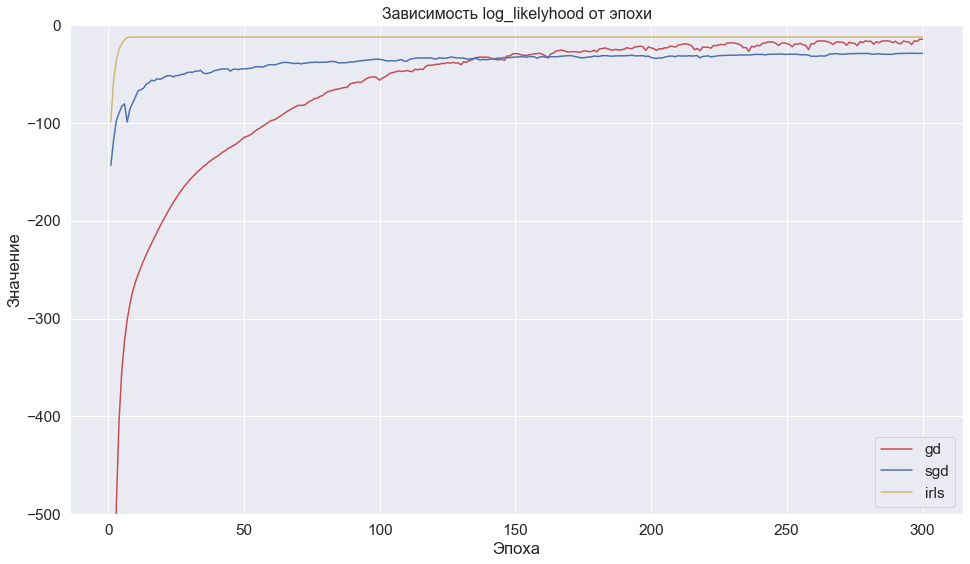

In [502]:
max_iter = 300

models = [LogisticRegression(criterion='max_iter', max_iter=max_iter, method='gd', lr=0.1), \
          LogisticRegression(criterion='max_iter', max_iter=max_iter, method='sgd', lr=0.1), \
          LogisticRegression(criterion='max_iter', max_iter=max_iter, method='irls', lr=0.1, alpha=0.01)]

colors = ['r', 'b', 'y']

num_iter = 10

plt.figure(figsize=(16, 9))

all_history = []

for i in range(len(models)):
    
    all_history_i = np.zeros(shape=(max_iter, 2))
    for j in range(num_iter):

        all_history_i = all_history_i + np.array(models[i].fit(X_train_sc, Y_train).history)
        models[i].fit(X_train_sc, Y_train).history = [] 
        
    all_history_i /= num_iter
    all_history.append(all_history_i)
    plt.plot(np.arange(1, max_iter + 1), all_history_i[:, 0], color=colors[i], label=models[i].method)
    
plt.legend()
plt.title('Зависимость log_likelyhood от эпохи', fontsize=16)
plt.xlabel("Эпоха")
plt.ylabel('Значение')
plt.ylim((-500, 0))
plt.show()

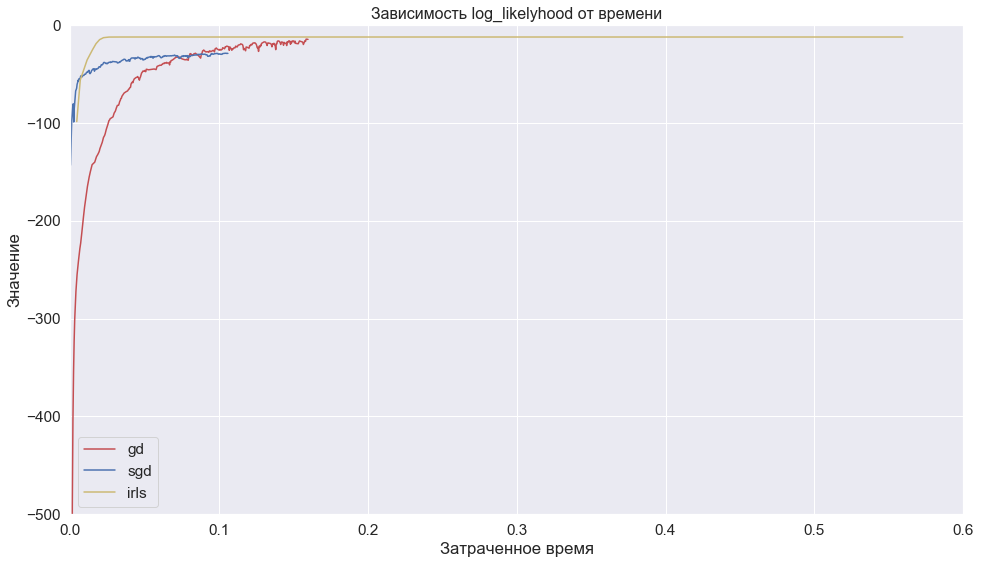

In [503]:
plt.figure(figsize=(16, 9))

for i in range(len(models)):
    
    plt.plot(all_history[i][:, 1], all_history[i][:, 0], color=colors[i], label=models[i].method)
    
plt.legend()
plt.title('Зависимость log_likelyhood от времени', fontsize=16)
plt.xlabel("Затраченное время")
plt.ylabel('Значение')
plt.ylim((-500, 0))
plt.xlim((0, 0.6))
plt.show()

***Краткий вывод***: как видно из графиков, все три модели сходятся, но при этом в окрестности предела для каждой из моделей наблюдаются разные значения log_likelyhood. Единственный метод, который сошелся - IRLS. Причем, он сделал это быстрее других методов. Обычный градиентный спуск же еще до конца не "нащупал" минимум, стохастический под конец менялся меньше.  
Касательно времени - даже из обрезанного по оси времени графику видно, что irls прошел всего 300 эпох за гораздо большее количество времени, чем остальные методы. Стохастический же закончил быстрее обычного.
Но стоит принять во внимание, что выборка у нас была достаточно небольшой. При сильно большем размере выборки или признаков из-за умножения огромных матриц обычный градиентный будет работать сильно дольше, а irls, из-за обращения матрицы, будет проблематично использовать при большом количестве итераций.

**3.** Сравните два реализованных критерия остановки по количеству проведенных итераций: евклидова норма разности текущего и нового векторов весов стала меньше, чем 1e-4 и ограничение на число итераций (например, 10000). Используйте градиентный спуск.

In [468]:
log_reg_iters = LogisticRegression(criterion='max_iter', max_iter=10000, method='gd', lr=0.1)
iters = log_reg_iters.fit(X_train_sc, Y_train).n_iter_
print("С ограничением по числу итераций: ", iters, " итераций")
log_reg_time = LogisticRegression(criterion='eps', eps=1e-4, method='gd', lr=0.1)
iters = log_reg_time.fit(X_train_sc, Y_train).n_iter_
print("С условием на eps: ", iters, " итераций")

С ограничением по числу итераций:  10000  итераций
С условием на eps:  467705  итераций


Как видно, подобное условие на eps потребовало от нас почти в 50 раз больше операций. Поэтому стоит быть аккуратнее с требуемой точностью - каждый знак после запятой будет требовать огромных времязатрат.

**4.** Рассмотрите как влияет размер шага (`learning rate`) на качество модели. Обучите каждую модель одинаковое число итераций (например, 10000), а затем посчитайте качество. Воспользуйтесь ограничением на число итераций в качестве критерия остановки, так как для больших `learning rate` у вас может не сойтись модель. Используйте стохастический градиентный спуск. Сделайте выводы.

In [522]:
lrs = [0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2, 5, 10]
X_test_sc = scaler.transform(X_test)
for i in range(len(lrs)):
    log_reg_sgd = LogisticRegression(criterion='max_iter', max_iter=10000, method='sgd', lr=lrs[i])
    log_reg_sgd.fit(X_train_sc, Y_train)
    print('-----------------------------------------------------------------------------------------')
    y_pred = log_reg_sgd.predict(X_test_sc)
    acc = accuracy_score(y_pred, Y_test)
    print('coefs: ', log_reg_sgd.weights)
    print('\n SGD, lr = ', lrs[i], ' accuracy: ', acc)
    print('-----------------------------------------------------------------------------------------')

-----------------------------------------------------------------------------------------
coefs:  [-0.45136226 -0.50096451 -0.23416628 -0.58396888 -0.11885335  0.65416714
 -0.80601129 -1.42520137  0.48602734  0.20273453 -1.75487816  0.13543885
 -0.90417508 -1.35239367 -0.510818    1.09298115  0.22536427 -0.46245153
  0.6046306   0.96237279 -1.13938991 -1.66237365 -0.94236322 -1.1566766
 -0.75207877  0.12420069 -1.38145878 -1.11975859 -1.73623096 -0.29145444
  0.41065493]

 SGD, lr =  0.01  accuracy:  0.9824561403508771
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
coefs:  [ 0.11110342  0.277853    0.4609646  -0.10843761 -0.22457275  3.72425426
 -1.96109433 -4.31181855  1.41914852 -1.18604757 -5.30524065  0.55565026
 -0.18328885 -3.35286666 -1.21177246  0.04052627  3.26533496 -1.85185574
  1.87029587  1.99029203 -2.22509047 -3.55458157  0.14656292 -2.3957

Выше я вывел дополнительно коэффициенты модели, т.к. почти не отличающаяся accuracy в зависимости от lr заставила задуматься, что в данных присутствует какая-то скрытая зависимость. Заметим, коэффициенты возрастают с ростом lr, что логично.

Постройте кривые обучения для различных `learning rate`. Не обязательно рассматривать все `learning rate` из предыдущего задания, так как их слишком много, и график будет нагроможден. Возьмите около половины из них. Какой `learning rate` лучше выбрать? Чем плохи маленькие и большие `learning rate`?

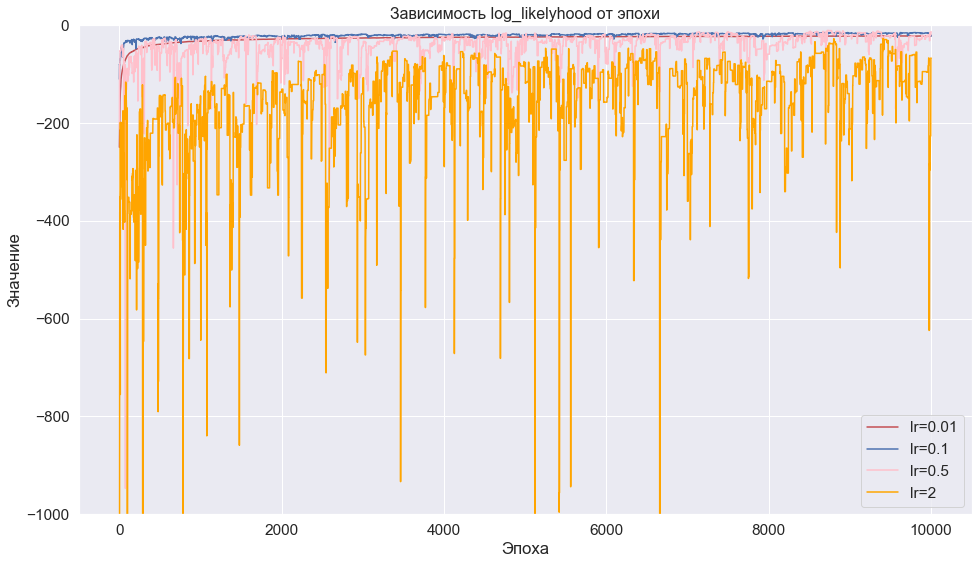

In [507]:
lrs = [0.01, 0.1, 0.5, 2]

colors = ['r', 'b', 'pink', 'orange']

plt.figure(figsize=(16, 9))
for i in range(len(lrs)):
    log_reg_sgd = LogisticRegression(criterion='max_iter', max_iter=10000, method='sgd', lr=lrs[i])
    log_reg_sgd.fit(X_train_sc, Y_train)
    
    history = np.array(log_reg_sgd.history)
    plt.plot(np.arange(1, 10001), history[:, 0], color=colors[i], label='lr={}'.format(lrs[i]))
    
plt.legend()
plt.title('Зависимость log_likelyhood от эпохи', fontsize=16)
plt.xlabel("Эпоха")
plt.ylabel('Значение')
plt.ylim((-1000, 0))
plt.show()

Из этих графиков можно заметить, что с ростом lr растет амплитуда скачков зависимости нашей целевой функции, т.к. оценка параметров становится неустойчивой. При этом, меньшие lr спокойно сходятся почти идеально. Но можно заметить, что lr=0.1 сходится лучше, чем lr=0.01, т.к. не стоит всегда уменьшать lr, из-за этого скорость сходимости будет медленней.

**5.** Рассмотрите несколько моделей, в которых установите не менее 5-ти различных коэффициентов регуляризации, а также модель без регуляризатора. Сравните, влияет ли наличие регуляризации на скорость сходимости и качество, сделайте выводы. Под качеством подразумевается значение метрики, рассмотренных на семинаре.

alpha:  [0.9824561403508771, 0.9912280701754386, 0.9824561403508771, 0.9912280701754386, 0.9912280701754386]
alpha:  [0.9649122807017544, 0.9736842105263158, 0.9736842105263158, 0.9736842105263158, 0.9824561403508771]
alpha:  [0.9385964912280702, 0.9385964912280702, 0.9736842105263158, 0.9385964912280702, 0.9824561403508771]


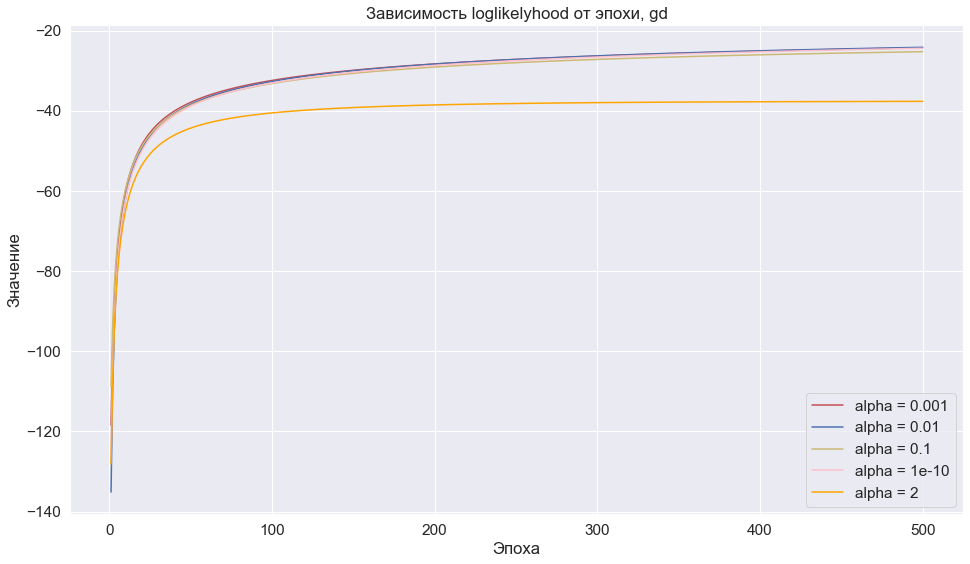

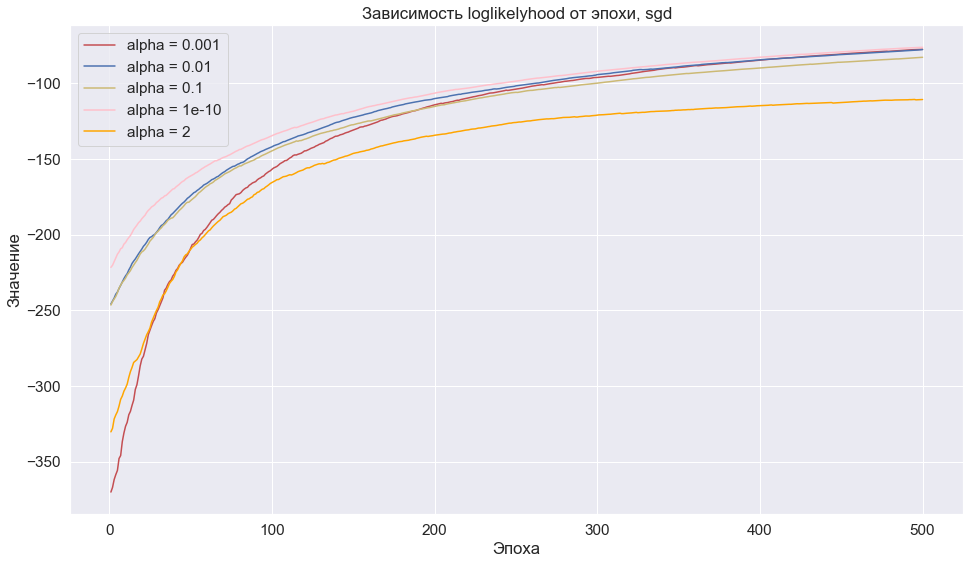

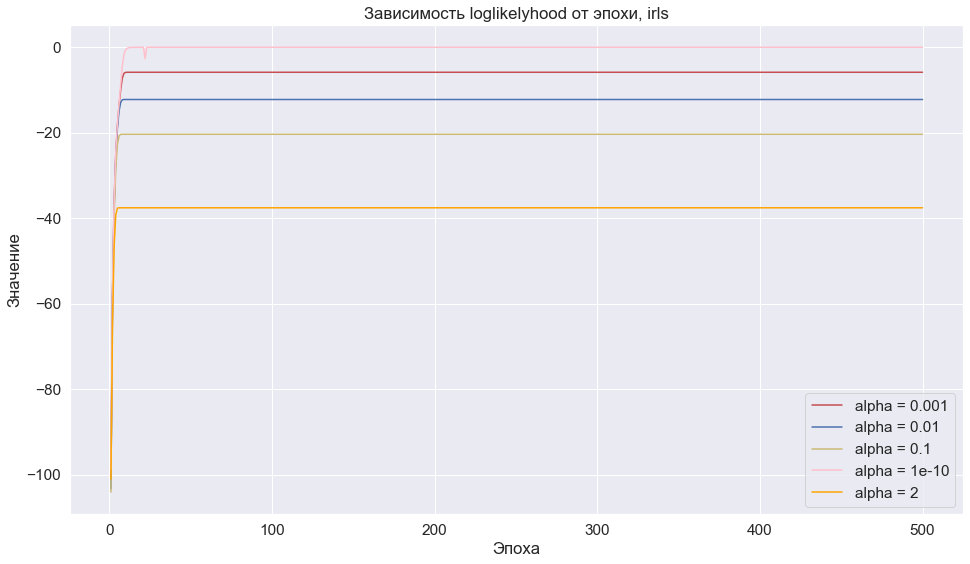

In [536]:
alphas = [0.001, 0.01, 0.1, 0.0000000001, 2]

models = ['gd', 'sgd', 'irls']
max_iter = 500

colors = ['r', 'b', 'y', 'pink', 'orange']

for i in range(len(models)):
    history = []
    acc = []
    plt.figure(figsize=(16, 9))
    for j in range(len(alphas)):
        model = LogisticRegression(alpha=alphas[j], criterion='max_iter', method=models[i], max_iter=max_iter)
        model.fit(X_train_sc, Y_train)
        history.append(np.array(model.history))
        acc.append(accuracy_score(model.predict(X_test_sc), Y_test))
        plt.plot(np.arange(1, max_iter + 1), history[-1][:, 0], label="alpha = " + str(alphas[j]), c=colors[j])
    print("alpha: ", acc)
    plt.title("Зависимость loglikelyhood от эпохи, {}".format(models[i]))
    plt.xlabel("Эпоха")
    plt.ylabel("Значение")
    plt.legend()

Как видно, хоть наибольший loglikelyhood и показывает irls, лучшей по качеству accuracy является модель gd с alpha=0.01. (0.0000000001 ~ 0)  
Предпочту gd sgd, т.к. вычислительной мощи хватит, а градиентный спуск более стабилен.

**6.** Выберите произвольные два признака, в пространстве которых визуализируйте предсказания вероятностей класса 1 для модели, которая показала наилучшее качество на предыдущем шаге.

Выберем два признака

In [534]:
ind = np.random.randint(0, 32, size=2)
    
X_train = X_train[:, ind]
X_test = X_test[:, ind]

Объявим и обучим наилучшую модель

In [540]:
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [542]:
model = LogisticRegression(alpha=0.01, criterion='max_iter', method='gd', max_iter=max_iter)
model.fit(X_train_sc, Y_train)

Рисуем

In [546]:
x0_grid, x1_grid = np.meshgrid(np.linspace(-1.5, 1.5, 2001), 
                               np.linspace(-1.5, 1.5, 2001))
ravel_grid = np.array([x0_grid, x1_grid]).reshape((2, 2001*2001)).T
prob_grid = model.predict_proba(ravel_grid)
prob_grid = prob_grid[:, 0].reshape((2001, 2001))
plt.figure(figsize=(12, 12))
plt.pcolormesh(x0_grid, x1_grid, prob_grid, cmap='Oranges')
plt.scatter(X_test_sc[:, 0], X_test_sc[:, 1], c=Y_test, alpha=0.8, cmap='Accent')
plt.xlim((-1.5, 1.5)), plt.ylim((-1.5, 1.5))
plt.xlabel('Признак 1'), plt.ylabel('Признак 2')
plt.title('Предсказание вероятности класса')
plt.show()

По подобному графику можно увидеть, что переобучения скорее всего не произошло. Наша модель не попыталась определить окруженный классом grey объект green. да и в целом, разделяющая плоскость проведена достаточно хорошо.  
Отмечу, что хоть предсказания и даны на объектах, к которым применен scaller, если их перевести обратно в старое признаковое пространство, ничего не изменится, т.к. просто произойдут смещение всех точек в одинаковом направлении и увеличение расстояния между ними.